# DSCI 100 Group 177 - Group Project Report

### Title: Predicting the round of a tennis tournament in which a match takes place based on the match participants' ATP rankings and ranking points

In [15]:
# Please run this cell before continuing, installing packages if necessary.
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
set.seed(2019)
options(repr.plot.width = 14, repr.plot.height = 8)

### Introduction:

**Background:** The Association of Tennis Professionals (ATP) holds many single-elimination tournaments annually, and uses a merit-based method to rank all professional men’s tennis players based on their performances in ATP-sanctioned tournaments over the previous 12 months. The farther a player progresses in a tournament, the more points they will gain in the rankings. Therefore, each player has both a ranking and a number of points which determines their ranking relative to others. In each ATP tournament, a draw (or bracket) is set up which ensures that highly-ranked players are not likely to meet each other too early in the tournament, making it more likely that the later rounds will include highly-ranked players playing one another.

**Our question:** We would like to attempt to predict the round of a tennis tournament (final, semi-final, quarter-final, round of 16, etc.) in which a match occurs using predictor variables such as the ranks of the winner and loser, as well as their points in the ATP rankings.

**Our dataset:** Our dataset contains all of the match results for matches involving the top 500-ranked players from the years 2017-2019, with each row/observation corresponding to one match. The data for each match includes the competitors’ identities, rankings, ranking points, the round of the tournament in which the match occurred, and other metrics concerning the performance of the players in the match. We will only be using data from the year 2019, and for matches that are part of a single-elimination tournament (no round-robin matches).

### Methods & Results:

***WRITE METHODS & RESULTS HERE***

In [20]:
# READING IN AND WRANGLING THE DATA

tennis_data <- read_csv("https://raw.githubusercontent.com/ben-westmore/dsci-100-2022w1-group-177/main/atp2017-2019.csv") |>
    mutate(round = as_factor(round),
           tourney_year = as.double(substr(tourney_date, 1, 4)),
           tourney_month = as.double(substr(tourney_date, 5, 6)),
           tourney_day = as.double(substr(tourney_date, 7, 8))) |>
    filter(round != 'BR',
           round != 'RR',
           tourney_year == 2019) |>
    select(-1, -tourney_date)

tennis_data <- tennis_data[, c(1:5, 49:51, 6:48)]    

tennis_data$round <- factor(tennis_data$round, levels = c("F", "SF", "QF", "R16", "R32", "R64", "R128"))


# CHECKING FOR BREAKDOWN OF MATCHES BY MATCH FORMAT (BEST OF 3 v BEST OF 5)

matches_by_length <- tennis_data |>
    group_by(best_of) |>
    summarize(number_of_matches = n())

matches_by_length


# FILTERING TO ONLY INCLUDE BEST OF 3 DATA, & MAKING A NEW STATISTIC TO TRY AS A PREDICTOR

tennis_data <- tennis_data |>
    filter(best_of == 3) |>
    mutate(w_over_l_point_ratio = winner_rank_points/loser_rank_points)

head(tennis_data)
# glimpse(tennis_data)
levels(tennis_data$round)

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


best_of,number_of_matches
<dbl>,<int>
3,1881
5,476


tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_year,tourney_month,tourney_day,match_num,winner_id,⋯,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,w_over_l_point_ratio
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-0301,Auckland,Hard,32,A,2019,1,7,300,105815,⋯,23,11,9,8,12,63,814,93,616,1.3214286
2019-0301,Auckland,Hard,32,A,2019,1,7,299,111815,⋯,45,13,15,7,10,93,616,58,855,0.7204678
2019-0301,Auckland,Hard,32,A,2019,1,7,298,105815,⋯,24,10,9,5,8,63,814,34,1125,0.7235556
2019-0301,Auckland,Hard,32,A,2019,1,7,297,111815,⋯,36,13,10,4,5,93,616,50,933,0.6602358
2019-0301,Auckland,Hard,32,A,2019,1,7,296,105526,⋯,72,23,18,13,15,58,855,24,1705,0.5014663
2019-0301,Auckland,Hard,32,A,2019,1,7,295,105815,⋯,27,18,10,6,7,63,814,54,895,0.9094972


[1] "F"    "SF"   "QF"   "R16"  "R32"  "R64"  "R128"

round,w_1stIn,w_df,l_1stIn,l_df,winner_rank,winner_rank_points,loser_rank,loser_rank_points,w_over_l_point_ratio
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F,37,2,39,2,63,814,93,616,1.3214286
SF,76,5,61,5,93,616,58,855,0.7204678
SF,33,0,36,2,63,814,34,1125,0.7235556
QF,48,0,52,3,93,616,50,933,0.6602358
QF,80,3,104,2,58,855,24,1705,0.5014663
QF,41,1,40,0,63,814,54,895,0.9094972


round,number_of_matches,percentage_of_matches
<fct>,<int>,<dbl>
F,40,2.84
SF,87,6.17
QF,171,12.14
R16,327,23.21
R32,555,39.39
R64,187,13.27
R128,42,2.98


Warning message:
“Removed 114 rows containing missing values (geom_point).”


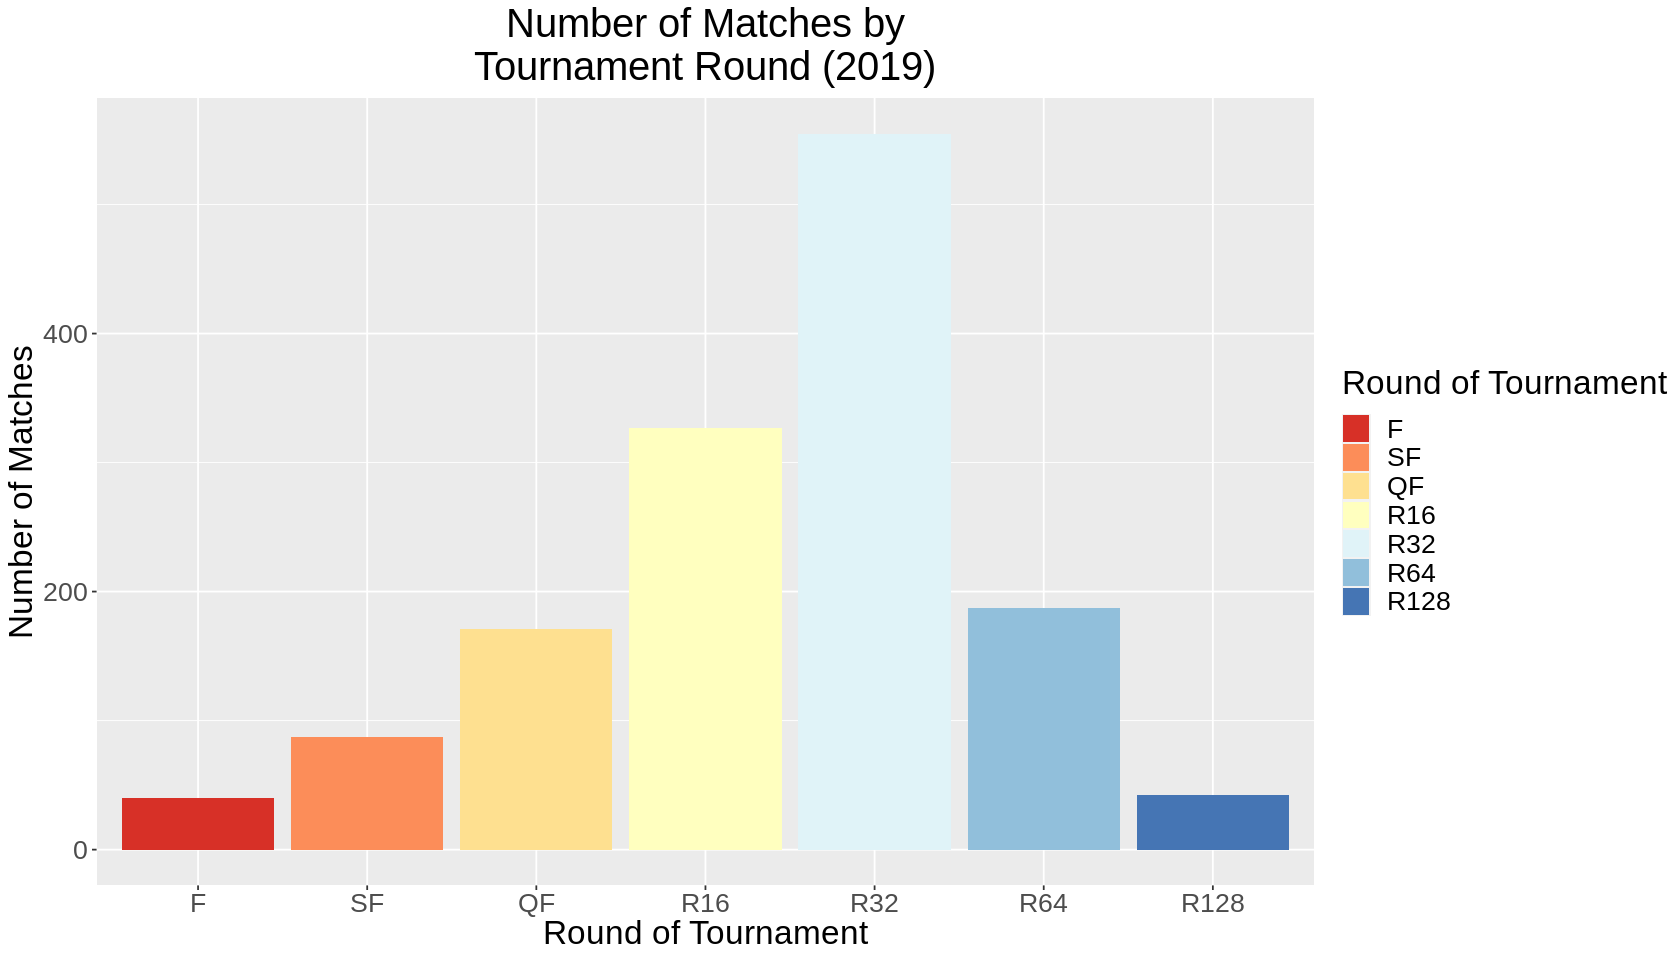

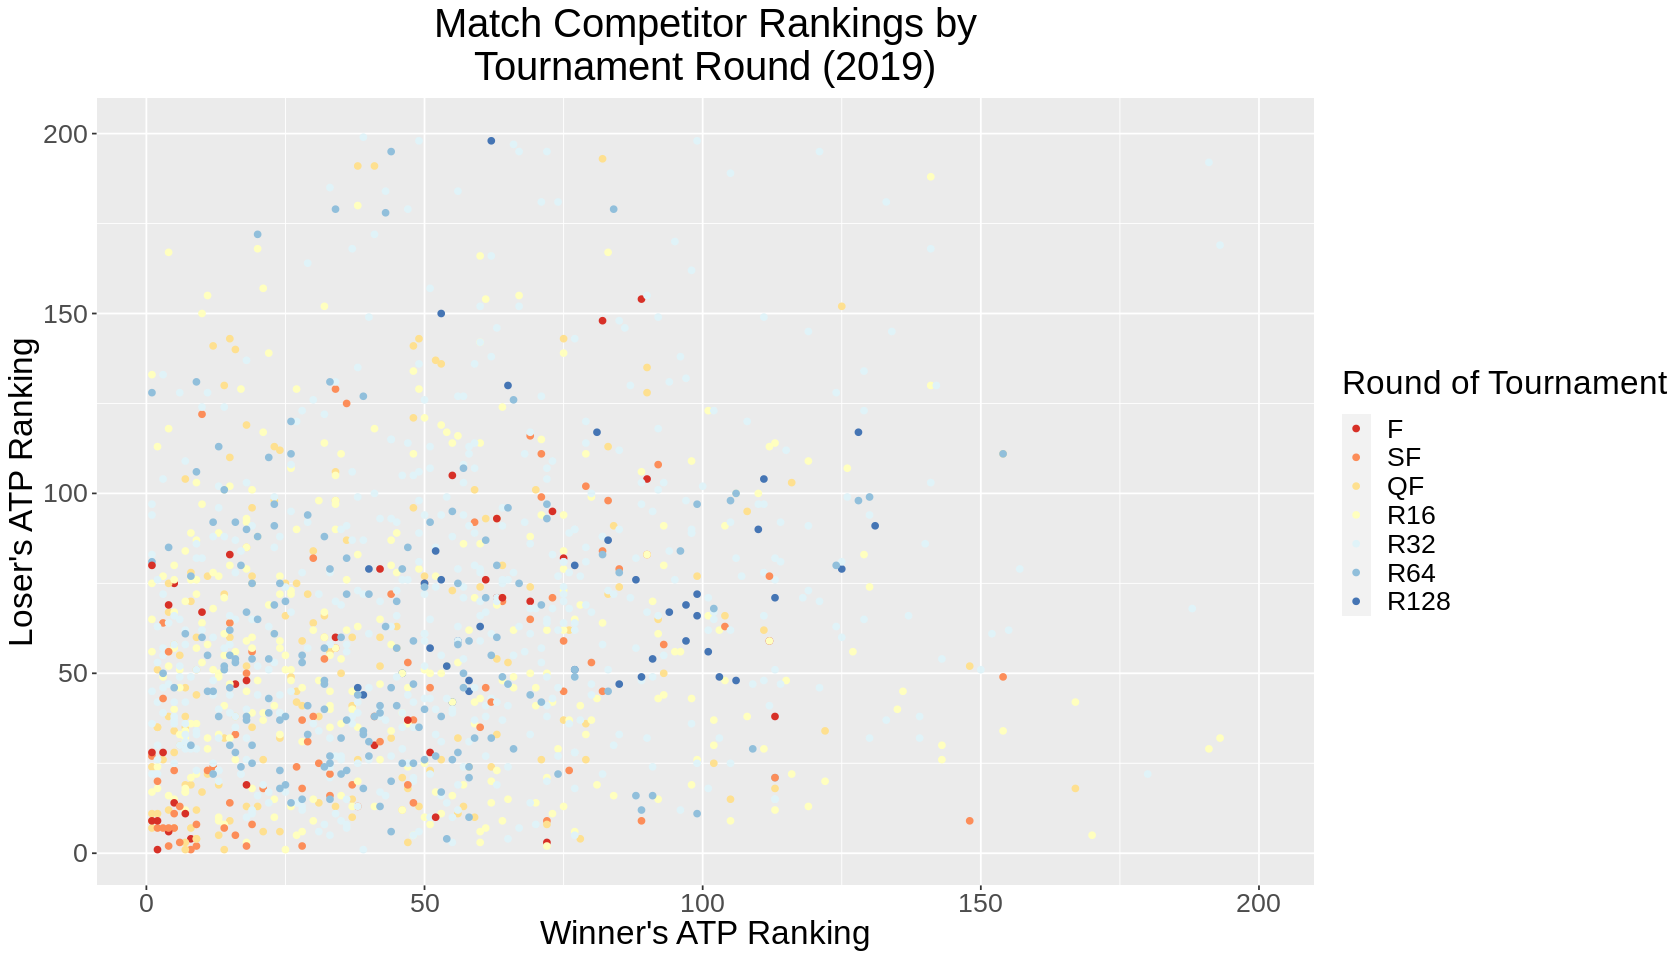

In [23]:
# MAKING A NEW TIBBLE THAT ONLY INCLUDES THE PREDICTORS WE WILL TRY

tennis_analysis_data <- tennis_data |>
    select(round,
           w_1stIn,
           w_df,
           l_1stIn,
           l_df,
           winner_rank,
           winner_rank_points,
           loser_rank,
           loser_rank_points,
           w_over_l_point_ratio)

head(tennis_analysis_data)

# SPLITTING THE DATA INTO TRAINING AND TESTING SETS

tennis_split <- initial_split(tennis_analysis_data, prop = 0.75, strata = round)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

# MAKING A TABLE TO SHOW BREAKDOWN OF MATCHES BY ROUND IN THE TRAINING SET

matches_by_round <- tennis_train |>
    group_by(round) |>
    summarize(number_of_matches = n(),
              percentage_of_matches = (round((n()/nrow(tennis_train)) * 100, 2)))

matches_by_round

# VISUALIZING THE MATCHES BY ROUND IN THE TRAINING SET

matches_by_round_plot <- ggplot(matches_by_round, aes(x = round, y = number_of_matches, fill = round)) +
    geom_bar(stat = "identity") +
    labs(title = "Number of Matches by\nTournament Round (2019)",
         x = "Round of Tournament",
         y = "Number of Matches",
         fill = "Round of Tournament") +
    scale_fill_brewer(palette = "RdYlBu") +
    theme(text = element_text(size = 20),
          plot.title = element_text(hjust = 0.5))

matches_by_round_plot

# VISUALIZING THE RANKINGS OF THE WINNER AND LOSER, COLOURED BY TOURNAMENT ROUND

rankings_vs_round_plot <- ggplot(tennis_train, aes(x = winner_rank, y = loser_rank, colour = round)) +
    geom_point() +
    labs(title = "Match Competitor Rankings by\nTournament Round (2019)",
         x = "Winner's ATP Ranking",
         y = "Loser's ATP Ranking",
         colour = "Round of Tournament") +
    lims(x = c(1, 200), y = c(1, 200)) +
    theme(text = element_text(size = 20),
          plot.title = element_text(hjust = 0.5)) +
    scale_color_brewer(palette = "RdYlBu")

rankings_vs_round_plot

### Methods ***(REMOVE)***:

We will conduct our data analysis from a classification standpoint, using cross-validation to evaluate optimal model specifications and forward selection to evaluate the accuracy when using several different subsets of predictors to determine which variables we will use to predict the tournament round apart from player rankings and ranking points.

**Potential visualizations:** One way in which we may visualize our results would be a plot of the ratio of ranking points between the two players (winner ranking points/loser ranking points) to the round of the match, assuming that the greater the discrepancy between the players, the earlier in a tournament the match would be. Another possible visualization could be the winner’s rank plotted against the loser’s rank, coloured by the round of the match, with more advanced matches likely to be located near the origin of the plot.

### Discussion ***(CHANGE, this is from the proposal)***:

**Expected findings:** We expect to find that if both of the players in a match are highly ranked and/or have a large number of points in the ATP rankings, the match will be occurring in a later round (e.g. final or semifinal). Additionally, we predict that the bigger the discrepancy between the players’ points/rankings, the earlier in the tournament the match will be due to the nature of how the tournament draws are formed.

**Potential impact:** We are hoping that the insights gained from this project will help people build some intuition regarding how tennis tournaments are set up, and give them the ability to make an educated guess about the stage of a tournament they are likely to be watching based on the quality of the two players involved.

**Potential future questions:**
- Is there any way we could go a step further and predict the winner of a tournament based on the tournament draw and previous results? If not, what unconsidered factors might influence the results?
- Once we determine what the best predictor variables are for our question, will we be able to use them to predict other facts about a tournament?

### References

***ADD REFERENCES HERE***